# Business Problem

**Definición del problema:**
La empresa de transporte bajo demanda busca mejorar la eficiencia operativa y reducir costos relacionados con la sobre o suboferta de conductores (drivers) en la ciudad. 

El objetivo principal es predecir la demanda de pasajeros a nivel temporal, anticipando en qué momentos del día y en qué días del mes se necesitarán más o menos conductores. 

Esto permitirá optimizar la disponibilidad de vehículos en la ciudad, reduciendo tanto la pérdida de clientes por falta de conductores como los costos derivados de tener demasiados conductores inactivos.

**Objetivo del proyecto:**
Construir un modelo de machine learning capaz de predecir la cantidad de viajes que se solicitarán en una franja horaria específica, basándose en datos históricos de viajes y otras variables relacionadas (día de la semana, hora, etc.).

**Impacto esperado:**
- Reducción de tiempos de espera para los usuarios.
- Optimización de la cantidad de conductores disponibles.
- Reducción de costes operativos por exceso de conductores.
- Mejora de la experiencia del usuario y eficiencia del negocio.

# Datos

## Definición de Datos

Para abordar este proyecto, utilizaremos datos reales de viajes de taxis amarillos de la ciudad de Nueva York, proporcionados por la NYC Taxi and Limousine Commission (TLC). Estos datos contienen un histórico detallado de los viajes realizados y nos servirán para entender la demanda de pasajeros y modelar las predicciones.

### Fuente de los datos

- **Dataset:** NYC Yellow Taxi Trips - Enero 2024  
- **Formato:** `.parquet`  
- **Enlace de descarga:** [Descargar datos](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet)

### Variables disponibles

El dataset incluye, entre otras, las siguientes columnas relevantes:

- Fecha y hora de recogida y entrega.
- Ubicación de origen y destino (zonas).
- Duración y distancia del viaje.
- Tarifa total y cargos adicionales.

### Descripción general

Estos datos nos permitirán analizar la distribución temporal de la demanda y patrones de comportamiento de los pasajeros durante el mes de **enero de 2024**. Aunque los datos provienen de taxis, el patrón de demanda es comparable al de plataformas como Uber o Lyft.

### Consideraciones

- Se almacenarán localmente en la carpeta `/data` del proyecto.
- Posteriormente, realizaremos un proceso de limpieza y análisis exploratorio (EDA) para preparar los datos para el modelado.
- Algunos registros pueden contener valores nulos o inconsistencias que deberán ser tratadas.



# Cargar datos

Vamos a cargar los datos para nuestro proyecto.

In [52]:
import pandas as pd

df_raw = pd.read_parquet('../data/raw/rides_2024_01.parquet')

df_raw.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


# Limpieza y preprocesamiento datos

## Validar datos

In [53]:
# nos quedamos con las columnas que nos interesan
# tpep_pickup_datetime: fecha y hora de recogida
# PULocationID: identificador de la zona de recogida
rides = df_raw[['tpep_pickup_datetime','PULocationID']].copy()

# renombramos las columnas
rides.rename(
    columns = {'tpep_pickup_datetime':'pickup_datetime', 
               'PULocationID':'pickup_location_id'}, inplace = True)

rides.head(20)


,pickup_datetime,pickup_location_id
0,2024-01-01 00:57:55,186
1,2024-01-01 00:03:00,140
2,2024-01-01 00:17:06,236
3,2024-01-01 00:36:38,79
4,2024-01-01 00:46:51,211
5,2024-01-01 00:54:08,148
6,2024-01-01 00:49:44,138
7,2024-01-01 00:30:40,246
8,2024-01-01 00:26:01,161
9,2024-01-01 00:28:08,113


In [54]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 2 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_datetime     datetime64[ns]
 1   pickup_location_id  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 33.9 MB


In [55]:
# analizamos valores estadísticos
rides.describe(include='all',datetime_is_numeric=True)

,pickup_datetime,pickup_location_id
count,2964624,2.964624e+06
mean,2024-01-17 00:46:36.431095552,1.660179e+02
min,2002-12-31 22:59:39,1.000000e+00
25%,2024-01-09 15:59:19.750000128,1.320000e+02
50%,2024-01-17 10:45:37.500000,1.620000e+02
75%,2024-01-24 18:23:52.249999872,2.340000e+02
max,2024-02-01 00:01:15,2.650000e+02
std,NaN,6.362391e+01


Se observa que las fechas no son las adecuadas.

Debería empezar en 1 de enero de 2024 y terminar en 31 de enero de 2024. 

Sin embargo, objservamos valores de 2002-12-31 22:59:39 que no deberían estar.

Tenemos que eliminar esas filas.

In [56]:
# nos quedamos con los datos de enero de 2024
rides = rides[rides.pickup_datetime >= '2024-01-01'] # después 1 de enero de 2024 inclusive
rides = rides[rides.pickup_datetime < '2024-02-01'] # antes 1 de febrero de 2024 no inclusive

# volvemos a analizar valores estadísticos
rides['pickup_datetime'].describe(include='all',datetime_is_numeric=True)

count                          2964606
mean     2024-01-17 01:02:08.093335808
min                2024-01-01 00:00:00
25%                2024-01-09 15:59:24
50%                2024-01-17 10:45:42
75%                2024-01-24 18:23:53
max                2024-01-31 23:59:55
Name: pickup_datetime, dtype: object

In [57]:
# guardamos los datos trasnformados
rides.to_parquet('../data/transformed/validated_rides_2024_01.parquet')

In [58]:
rides.head()

,pickup_datetime,pickup_location_id
0,2024-01-01 00:57:55,186
1,2024-01-01 00:03:00,140
2,2024-01-01 00:17:06,236
3,2024-01-01 00:36:38,79
4,2024-01-01 00:46:51,211


##  Transformar datos en series temporales

Para poder predecir los pasajeros que habrá en la siguiente hora para una localización, tenemos que saber cuántos pasajeros hay en horas anteriores para dicha localización.

Por lo tanto, para cada localización, vamos a tener un target que será una hora, y unas features que sean las N horas anteriores.

Vamos a coger un intervalo de 24 horas anteriores.

Para dichas horas, tendremos que agrupar y quedarnos con los pasajeros para esa hora y esa localización, ya que están por minutos y segundos por cada localización.

In [59]:
# creamos una nueva columna con la hora de recogida
# la función dt.floor('H') redondea la hora al inicio de la hora
# por ejemplo, 12:34:56 se redondea a 12:00:00
rides['pickup_hour'] = rides['pickup_datetime'].dt.floor('H')
rides.head()

,pickup_datetime,pickup_location_id,pickup_hour
0,2024-01-01 00:57:55,186,2024-01-01
1,2024-01-01 00:03:00,140,2024-01-01
2,2024-01-01 00:17:06,236,2024-01-01
3,2024-01-01 00:36:38,79,2024-01-01
4,2024-01-01 00:46:51,211,2024-01-01


In [60]:
# agrupamos por hora y zona de recogida
# y contamos el número de viajes en cada grupo
# el resultado es un DataFrame con tres columnas:
# pickup_hour, pickup_location_id y num_rides
rides_agg = rides.groupby(['pickup_hour', 'pickup_location_id']).size().reset_index(name='rides')
rides_agg.head()

,pickup_hour,pickup_location_id,rides
0,2024-01-01,4,25
1,2024-01-01,7,4
2,2024-01-01,9,1
3,2024-01-01,10,6
4,2024-01-01,12,4


Vamos a asegurar que no falte ninguna combinación de hora y localización en el dataset.

¿Por qué es necesario?
Cuando agrupas por `pickup_hour` y `pickup_location_id`, solo aparecen las combinaciones donde realmente hubo rides. 

Pero, por ejemplo, si en una zona concreta (`pickup_location_id = 145`) a las 3 AM no hubo ningún ride, esa combinación ni siquiera aparecerá en tu dataframe.

El problema es que:

- Los modelos de Machine Learning esperan series completas y homogéneas para cada localización y tiempo.
- Si faltan esos "slots vacíos", los lags y otras features temporales quedarán mal o incompletos.

En el siguiente código:

1- Generamos todas las combinaciones posibles de pickup_hour y pickup_location_id.
2- Luego hacemos un reindex() directo sobre ese multi-índice.
3- Mucho más rápido y limpio, especialmente si tienes muchas zonas.

In [61]:
# Creamos un rango completo de horas con todas las combinaciones posibles de hora y localización
# def add_missing_slots_simple(agg_rides: pd.DataFrame) -> pd.DataFrame:
# Crear el rango completo de horas
full_range = pd.date_range(
    rides_agg['pickup_hour'].min(),
    rides_agg['pickup_hour'].max(),
    freq='H'
)

# todas las horas posibles
full_range

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               ...
               '2024-01-31 14:00:00', '2024-01-31 15:00:00',
               '2024-01-31 16:00:00', '2024-01-31 17:00:00',
               '2024-01-31 18:00:00', '2024-01-31 19:00:00',
               '2024-01-31 20:00:00', '2024-01-31 21:00:00',
               '2024-01-31 22:00:00', '2024-01-31 23:00:00'],
              dtype='datetime64[ns]', length=744, freq='H')

In [62]:
# Obtener todas las combinaciones posibles de hora y localización
all_combinations = pd.MultiIndex.from_product(
    [full_range, rides_agg['pickup_location_id'].unique()],
    names=['pickup_hour', 'pickup_location_id']
)

# multiindex con todas las combinaciones posibles de hora y localización
all_combinations

MultiIndex([('2024-01-01 00:00:00',   4),
            ('2024-01-01 00:00:00',   7),
            ('2024-01-01 00:00:00',   9),
            ('2024-01-01 00:00:00',  10),
            ('2024-01-01 00:00:00',  12),
            ('2024-01-01 00:00:00',  13),
            ('2024-01-01 00:00:00',  14),
            ('2024-01-01 00:00:00',  16),
            ('2024-01-01 00:00:00',  17),
            ('2024-01-01 00:00:00',  18),
            ...
            ('2024-01-31 23:00:00', 184),
            ('2024-01-31 23:00:00', 172),
            ('2024-01-31 23:00:00', 221),
            ('2024-01-31 23:00:00',  84),
            ('2024-01-31 23:00:00', 187),
            ('2024-01-31 23:00:00',  58),
            ('2024-01-31 23:00:00', 105),
            ('2024-01-31 23:00:00', 109),
            ('2024-01-31 23:00:00', 199),
            ('2024-01-31 23:00:00', 245)],
           names=['pickup_hour', 'pickup_location_id'], length=193440)

In [63]:
# Reindexamos el DataFrame con todas las combinaciones posibles de hora y localización
# los valores que no existan en el DataFrame original se rellenan con 0
# el resultado es un DataFrame con tres columnas:
# pickup_hour, pickup_location_id y num_rides
rides_agg_full = (
    rides_agg
    .set_index(['pickup_hour', 'pickup_location_id'])
    .reindex(all_combinations, fill_value=0)
    .reset_index()
)

# Comprobamos que no faltan valores en la zona 4
rides_agg_full[rides_agg_full['pickup_location_id'] == 4].head(20)

,pickup_hour,pickup_location_id,rides
0,2024-01-01 00:00:00,4,25
260,2024-01-01 01:00:00,4,29
520,2024-01-01 02:00:00,4,34
780,2024-01-01 03:00:00,4,31
1040,2024-01-01 04:00:00,4,32
1300,2024-01-01 05:00:00,4,8
1560,2024-01-01 06:00:00,4,6
1820,2024-01-01 07:00:00,4,4
2080,2024-01-01 08:00:00,4,0
2340,2024-01-01 09:00:00,4,1


In [64]:
rides_agg_full[rides_agg_full['pickup_location_id'] == 4].tail(20)

,pickup_hour,pickup_location_id,rides
188240,2024-01-31 04:00:00,4,0
188500,2024-01-31 05:00:00,4,0
188760,2024-01-31 06:00:00,4,1
189020,2024-01-31 07:00:00,4,5
189280,2024-01-31 08:00:00,4,21
189540,2024-01-31 09:00:00,4,7
189800,2024-01-31 10:00:00,4,4
190060,2024-01-31 11:00:00,4,2
190320,2024-01-31 12:00:00,4,2
190580,2024-01-31 13:00:00,4,1


# EDA

## Análisis general

In [65]:
# Información general
print(rides_agg_full.info())
print(rides_agg_full.describe())

# Revisar valores nulos
print(rides_agg_full.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193440 entries, 0 to 193439
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         193440 non-null  datetime64[ns]
 1   pickup_location_id  193440 non-null  int64         
 2   rides               193440 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.4 MB
None
       pickup_location_id          rides
count       193440.000000  193440.000000
mean           133.938462      15.325713
std             76.730019      48.337041
min              1.000000       0.000000
25%             66.750000       0.000000
50%            135.500000       0.000000
75%            200.250000       2.000000
max            265.000000     726.000000
pickup_hour           0
pickup_location_id    0
rides                 0
dtype: int64


## Visualización del total de rides por hora (agregado global)

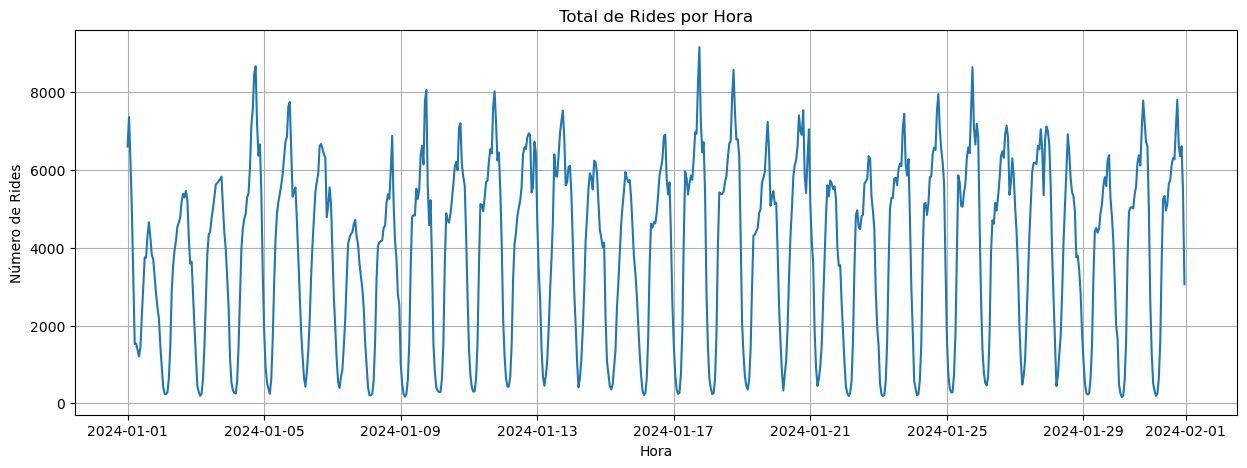

In [66]:
# importamos matplotlib.pyplot
import matplotlib.pyplot as plt

# agrupamos por hora y contamos el número de viajes en cada grupo
df_global = rides_agg_full.groupby('pickup_hour')['rides'].sum().reset_index()

# creamos un gráfico con el número total de viajes por hora
plt.figure(figsize=(15, 5))
plt.plot(df_global['pickup_hour'], df_global['rides'])
plt.title('Total de Rides por Hora')
plt.xlabel('Hora')
plt.ylabel('Número de Rides')
plt.grid(True)
plt.show()


*Observaciones*: 
- Se puede ver que hay estacionalidad en los datos.
- No parece que haya una tendencia

## Visualización de una localización

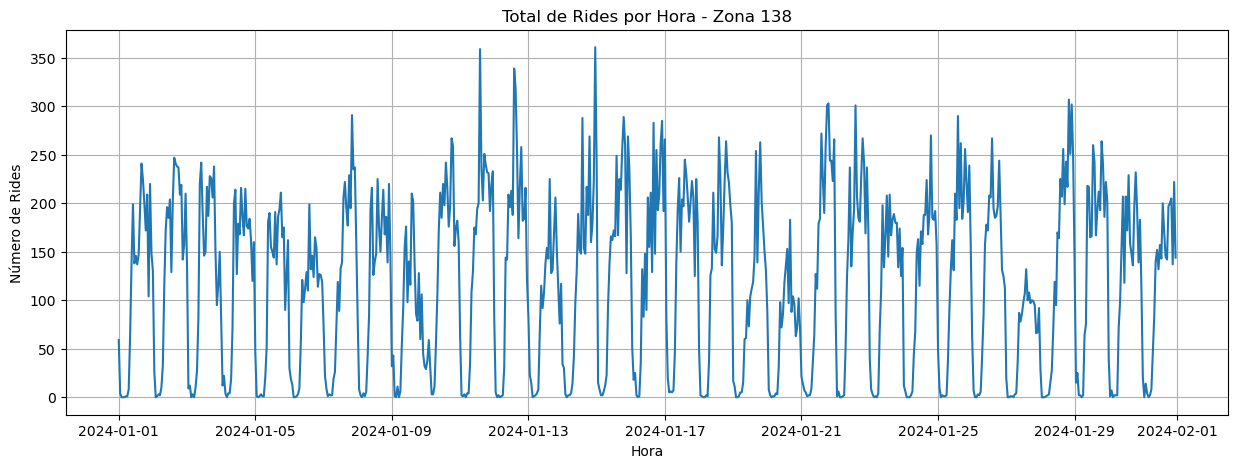

In [67]:
# importamos matplotlib.pyplot
import matplotlib.pyplot as plt

# definimos la zona que queremos graficar
location_id = 138  # puedes cambiar este valor por la zona que desees

# filtramos por la zona específica
df_zone = rides_agg_full[rides_agg_full['pickup_location_id'] == location_id]

# agrupamos por hora y contamos el número de viajes en cada grupo
df_zone = df_zone.groupby('pickup_hour')['rides'].sum().reset_index()

# creamos un gráfico con el número total de viajes por hora para esa zona
plt.figure(figsize=(15, 5))
plt.plot(df_zone['pickup_hour'], df_zone['rides'])
plt.title(f'Total de Rides por Hora - Zona {location_id}')
plt.xlabel('Hora')
plt.ylabel('Número de Rides')
plt.grid(True)
plt.show()


### Gráfico interactivo

In [68]:
from typing import Optional, List
import plotly.express as px

def plot_rides(
    rides: pd.DataFrame,
    locations: Optional[List[int]] = None
    ):
    """
    Plot time-series data
    """
    rides_to_plot = rides[rides.pickup_location_id.isin(locations)] if locations else rides

    fig = px.line(
        rides_to_plot,
        x="pickup_hour",
        y="rides",
        color='pickup_location_id',
        template='none',
    )

    fig.show()

plot_rides(rides_agg_full, locations=[43])

Se observa algo similar al global.

## Patrón diario (media de rides por hora del día)

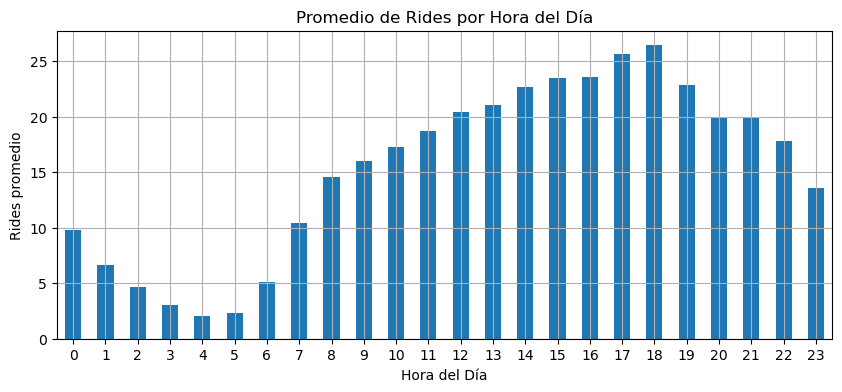

In [69]:
# creamos una nueva columna con la hora del día
rides_agg_full['hour_of_day'] = rides_agg_full['pickup_hour'].dt.hour

# agrupamos por hora del día y calculamos el número medio de viajes
hourly_pattern = rides_agg_full.groupby('hour_of_day')['rides'].mean()

# creamos un gráfico con el número medio de viajes por hora del día
plt.figure(figsize=(10, 4))
hourly_pattern.plot(kind='bar')
plt.title('Promedio de Rides por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Rides promedio')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


Podemos observar,según las medias por hora del día:
- Desde las 23:00 de un día y hasta las 8:00 am del día siguiente son horas con poca demanda.
- Desde las 12:00 hasta las 20:00 son las horas con mayor demanda
- Encontramos pico de demanda a las 17:00 y 18:00
- Encontramos mínimo de demanda a las 4:00

## Visualización promedio de Rides por día de la semana

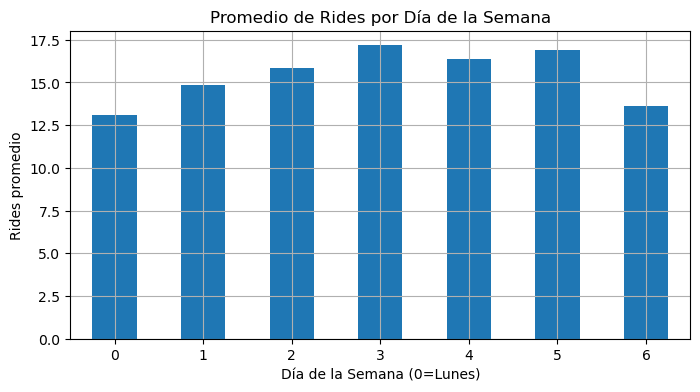

In [70]:
rides_agg_full['day_of_week'] = rides_agg_full['pickup_hour'].dt.dayofweek  # Lunes=0, Domingo=6

weekly_pattern = rides_agg_full.groupby('day_of_week')['rides'].mean()

plt.figure(figsize=(8, 4))
weekly_pattern.plot(kind='bar')
plt.title('Promedio de Rides por Día de la Semana')
plt.xlabel('Día de la Semana (0=Lunes)')
plt.ylabel('Rides promedio')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


Hay diferencia entre días, siendo jueves, viernes y sábado los días que más demanda hay.

Domingo y lunes los que menos.

## Top zonas con más rides

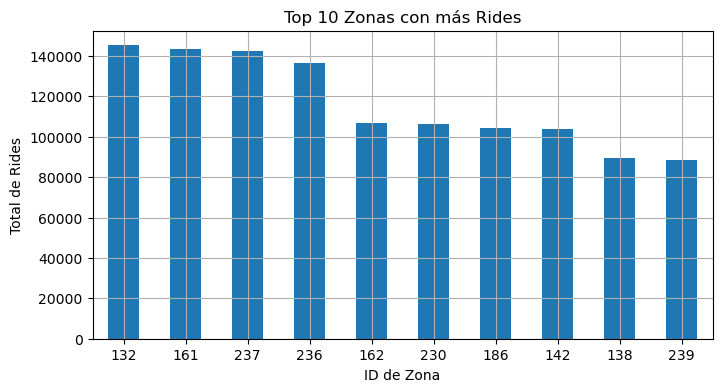

In [71]:
# calculamos el total de viajes por zona y seleccionamos las 10 zonas con más viajes
top_zones = rides_agg_full.groupby('pickup_location_id')['rides'].sum().sort_values(ascending=False).head(10)

# creamos un gráfico con el total de viajes por zona
plt.figure(figsize=(8, 4))
top_zones.plot(kind='bar')
plt.title('Top 10 Zonas con más Rides')
plt.xlabel('ID de Zona')
plt.ylabel('Total de Rides')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


Se pueden observar diferencias entre zonas con mayor y menor demanda.

## Descomposición de la serie temporal

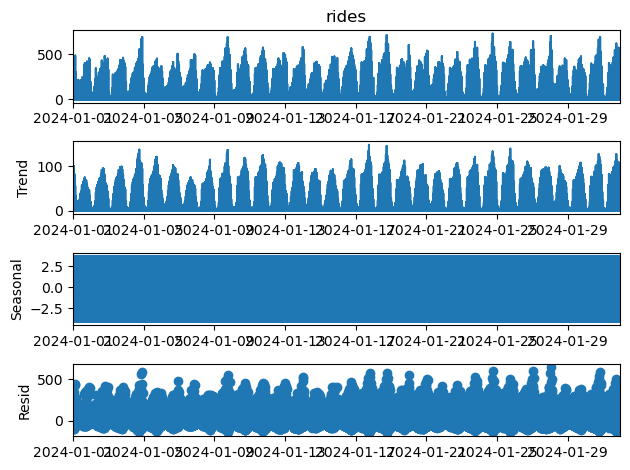

In [72]:
# importamos statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# descomponemos la serie temporal en tendencia, estacionalidad y residuo
result = seasonal_decompose(rides_agg_full.set_index('pickup_hour')['rides'], model='additive', period=24)
result.plot()
plt.show()


Es un resumene estadístico de series temporales.

Se observa lo que hemos estado advirtiendo anteriormente:
- No hay una tendencia clara
- Hay mucha estacionalidad diaria
- Hay algunos picos en algunos meses
- Por lo general, es bastante estable la demanda y no  muy variable

In [73]:
rides_agg_full.to_parquet('../data/transformed/ts_data_2024_01.parquet')

# Feature Engineering

In [74]:
ts_data_one_location = rides_agg_full.loc[rides_agg_full.pickup_location_id == 138, :].reset_index(drop=True)
ts_data_one_location.head(24)

,pickup_hour,pickup_location_id,rides,hour_of_day,day_of_week
0,2024-01-01 00:00:00,138,59,0,0
1,2024-01-01 01:00:00,138,4,1,0
2,2024-01-01 02:00:00,138,0,2,0
3,2024-01-01 03:00:00,138,0,3,0
4,2024-01-01 04:00:00,138,0,4,0
5,2024-01-01 05:00:00,138,1,5,0
6,2024-01-01 06:00:00,138,1,6,0
7,2024-01-01 07:00:00,138,8,7,0
8,2024-01-01 08:00:00,138,64,8,0
9,2024-01-01 09:00:00,138,139,9,0


In [75]:
def create_lag_features(df: pd.DataFrame, n_lags: int = 24) -> pd.DataFrame:
    """
    Crea n_lags features con retrasos (lags) para la serie temporal de rides.
    La columna target será el valor actual a predecir.
    
    Args:
        df (pd.DataFrame): DataFrame con columnas ['pickup_hour', 'rides'] de una sola localización.
        n_lags (int): número de lags que queremos generar.

    Returns:
        pd.DataFrame: dataframe con columnas rides_previous_N_hour y target
    """
    
    # Nos aseguramos de que esté ordenado por fecha
    df = df.sort_values('pickup_hour').reset_index(drop=True)
    
    # Creamos las columnas de lags
    for lag in range(n_lags, 0, -1):
        df[f'rides_previous_{lag}_hour'] = df['rides'].shift(lag)
    
    # La columna target será la demanda real de la hora actual
    df['target'] = df['rides']
    
    # Eliminamos la columna 'rides' original y las filas con NaN (las primeras n_lags)
    df = df.drop(columns=['rides'])
    df = df.dropna().reset_index(drop=True)

    df = df.drop(columns=['pickup_hour', 'pickup_location_id'])
    
    return df



# ts_data_one_location ya contiene solo una zona específica
df_features = create_lag_features(ts_data_one_location, n_lags=24)

X = df_features.drop(columns=['target'])
y = df_features['target']

# Mostramos la tabla
X.head(20)


,hour_of_day,day_of_week,rides_previous_24_hour,rides_previous_23_hour,rides_previous_22_hour,rides_previous_21_hour,rides_previous_20_hour,rides_previous_19_hour,rides_previous_18_hour,rides_previous_17_hour,...,rides_previous_10_hour,rides_previous_9_hour,rides_previous_8_hour,rides_previous_7_hour,rides_previous_6_hour,rides_previous_5_hour,rides_previous_4_hour,rides_previous_3_hour,rides_previous_2_hour,rides_previous_1_hour
0,0,1,59.0,4.0,0.0,0.0,0.0,1.0,1.0,8.0,...,147.0,193.0,241.0,225.0,200.0,172.0,209.0,104.0,220.0,149.0
1,1,1,4.0,0.0,0.0,0.0,1.0,1.0,8.0,64.0,...,193.0,241.0,225.0,200.0,172.0,209.0,104.0,220.0,149.0,130.0
2,2,1,0.0,0.0,0.0,1.0,1.0,8.0,64.0,139.0,...,241.0,225.0,200.0,172.0,209.0,104.0,220.0,149.0,130.0,27.0
3,3,1,0.0,0.0,1.0,1.0,8.0,64.0,139.0,199.0,...,225.0,200.0,172.0,209.0,104.0,220.0,149.0,130.0,27.0,0.0
4,4,1,0.0,1.0,1.0,8.0,64.0,139.0,199.0,138.0,...,200.0,172.0,209.0,104.0,220.0,149.0,130.0,27.0,0.0,1.0
5,5,1,1.0,1.0,8.0,64.0,139.0,199.0,138.0,146.0,...,172.0,209.0,104.0,220.0,149.0,130.0,27.0,0.0,1.0,3.0
6,6,1,1.0,8.0,64.0,139.0,199.0,138.0,146.0,137.0,...,209.0,104.0,220.0,149.0,130.0,27.0,0.0,1.0,3.0,2.0
7,7,1,8.0,64.0,139.0,199.0,138.0,146.0,137.0,147.0,...,104.0,220.0,149.0,130.0,27.0,0.0,1.0,3.0,2.0,10.0
8,8,1,64.0,139.0,199.0,138.0,146.0,137.0,147.0,193.0,...,220.0,149.0,130.0,27.0,0.0,1.0,3.0,2.0,10.0,33.0
9,9,1,139.0,199.0,138.0,146.0,137.0,147.0,193.0,241.0,...,149.0,130.0,27.0,0.0,1.0,3.0,2.0,10.0,33.0,114.0


In [76]:
df_features.to_parquet('../data/processed/features_target_2024_01.parquet')

# Entrenar modelos

## Train-test split

In [77]:
from sklearn.model_selection import train_test_split

# Dividimos en train y test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_features.drop(columns='target'), df_features['target'], 
    test_size=0.2, 
    random_state=42, 
    shuffle=False  # No barajamos porque es un problema temporal
)

y_train, X_train

(0      130
 1       27
 2        0
 3        1
 4        3
       ... 
 571    256
 572    222
 573    191
 574    239
 575    156
 Name: target, Length: 576, dtype: int64,
      hour_of_day  day_of_week  rides_previous_24_hour  rides_previous_23_hour  \
 0              0            1                    59.0                     4.0   
 1              1            1                     4.0                     0.0   
 2              2            1                     0.0                     0.0   
 3              3            1                     0.0                     0.0   
 4              4            1                     0.0                     1.0   
 ..           ...          ...                     ...                     ...   
 571           19            3                   270.0                   185.0   
 572           20            3                   185.0                   183.0   
 573           21            3                   183.0                   192.0   
 574  

## Train model

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Baseline con regresión lineal
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

LinearRegression()

# Evaluar modelos

In [79]:
# Predicciones
y_pred_baseline = baseline_model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred_baseline)
rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline (Regresión Lineal) - MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.2f}")

Baseline (Regresión Lineal) - MAE: 27.31 | RMSE: 35.47 | R2: 0.84


# Guardar modelos

In [80]:
import joblib

joblib.dump(baseline_model, '../models/linear_regression.pkl')

['../models/linear_regression.pkl']

## Entrenamos Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluación
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f} | RMSE: {rmse_rf:.2f} | R2: {r2:.2f}")

joblib.dump(rf_model, '../models/random_forest.pkl')


Random Forest - MAE: 20.85 | RMSE: 27.88 | R2: 0.90


['../models/random_forest.pkl']